# Metacells Manual Analysis Vignette

This vignette demonstrates a possible manual analysis of the metacells generated from the basic [metacells vignette](Metacells_Vignette.html). The latest version of this vignette is available in [Github](https://github.com/tanaylab/metacells/blob/master/sphinx/Metacells_Vignette.rst).

## Preparation

You should first run the basic metacells vignette to obtain the file `metacells.h5ad`. Next, we will require the R libraries we will be using:

In [1]:
require('anndata')
require('chameleon')
require('pheatmap')
require('pracma')
require('stats')
options(jupyter.plot_mimetypes = 'image/svg+xml')


Loading required package: anndata

Warning message:
“package ‘anndata’ was built under R version 4.1.0”
Loading required package: chameleon

Warning message:
“package ‘chameleon’ was built under R version 4.1.0”
Loading required package: pheatmap

Warning message:
“package ‘pheatmap’ was built under R version 4.1.0”
Loading required package: pracma

Warning message:
“package ‘pracma’ was built under R version 4.1.0”


## Getting the raw data

We will use the data generated by the metacells vignette, the `metacells.h5ad` file generated by it. We'll also read the list of forbidden genes for use below.

In [2]:
mdata <- anndata::read_h5ad('metacells.h5ad')

## Metacells Marker Genes

A possible starting point for anlayzing the data is looking at the genes that are different in each metacell vs. the rest of the population. Such marker genes are good candidates for investigating the captured cell behaviors. We'll start by converting the raw UMIs counts to a log scale for more convenient analysis:

In [3]:
umis <- as.matrix(mdata$X)
fractions <- umis / rowSums(umis)
log_fractions <- log2(1e-5 + fractions)

We can use this matrix to, for each metacell, look for a few genes that are most entriched in it compated to the overall population:

In [4]:
genes_per_metacell <- 2
minimal_max_log_fraction_of_interesting_genes <- -10
minimal_relative_log_fraction_of_candidate_genes <- 2

median_log_fractions_of_genes <- apply(log_fractions, 2, median)
relative_log_fractions <- sweep(log_fractions, 2, median_log_fractions_of_genes)
max_log_fractions_of_genes <- apply(log_fractions, 2, max)

interesting_genes_mask <- (max_log_fractions_of_genes
                        >= minimal_max_log_fraction_of_interesting_genes)
marker_genes <- unique(
    unlist(
        apply(
            relative_log_fractions[,interesting_genes_mask],
            1,
            function(relative_log_fraction_of_metacell) {
                candidate_genes_mask <- (relative_log_fraction_of_metacell
                                      >= minimal_relative_log_fraction_of_candidate_genes)
                names(
                    head(
                        sort(-relative_log_fraction_of_metacell[candidate_genes_mask]),
                        n=genes_per_metacell
                    )
                )
            }
        )
    )
)
print(length(marker_genes))

[1] 72


This gave us 84 genes to look at (you can get more or less genes modifying the parameters, especially `genes_per_metacell`). We can visualize the structure of the data using these genes, which could be a first step towards understaning the different cell behaviors:

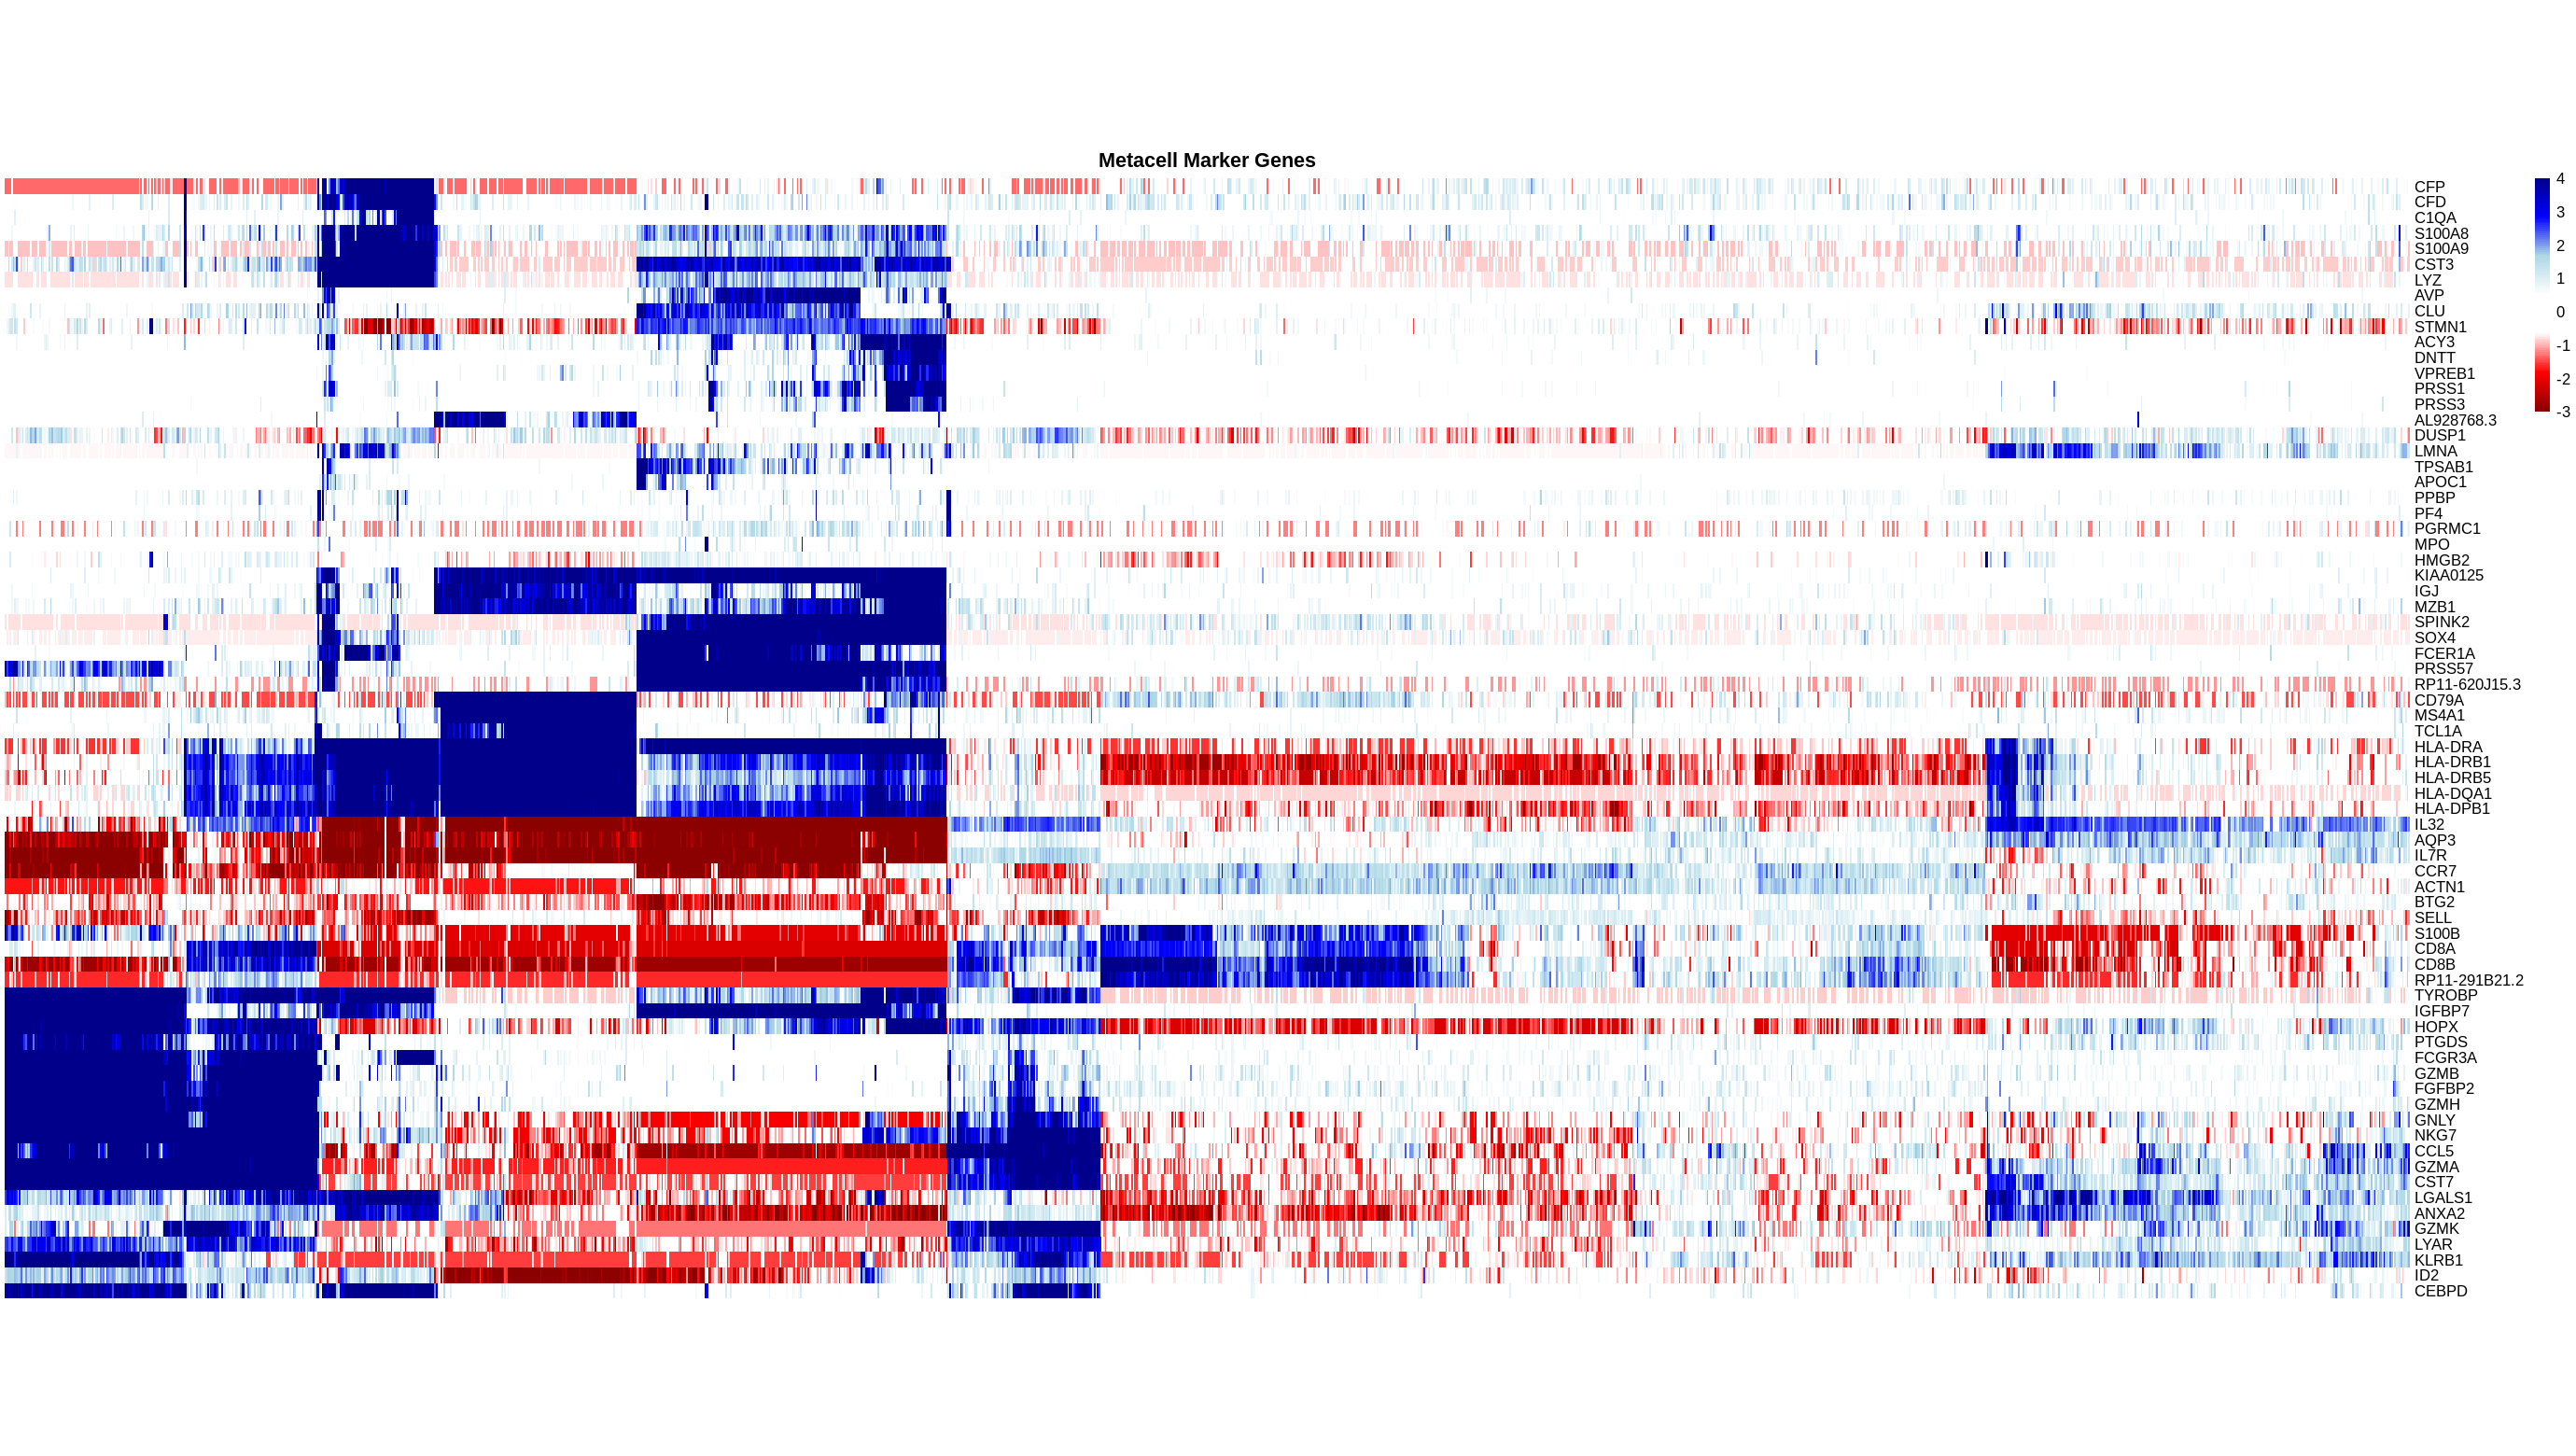

In [5]:
breaks <- pracma::interp1(0:7, c(-3, -2, -1, 0, 1, 2, 3, 4), 0:140/20)
colors <- colorRampPalette(c('darkred', 'red', 'white', 'white', 'lightblue', 'blue', 'darkblue'))(141)
options(repr.plot.width = 23, repr.plot.height = 13)
pheatmap::pheatmap(
    t(relative_log_fractions[,marker_genes]),
    treeheight_col=0,
    treeheight_row=0,
    cellwidth=1,
    cellheight=10,
    show_rownames=TRUE,
    show_colnames=FALSE,
    main='Metacell Marker Genes',
    color=colors,
    breaks=breaks,
    legend=TRUE
)

## Clustering

The 1st step we'll do is to cluster the metacells. Ideally, we'd have "similar" cell types in the same cluster and "different" cell behaviors in different clusters. The specific algorithm doesn't matter (much) as these clusters would only be used in guiding us towards understanding the true structure of the data. The key requirement is that the method will create clusters which are "homogeneous", even if at the cost of creating (a few) different clusters for "very similar" behaviors.

In this example, we  perform K-means analysis of the data (looking only at "interesting" genes), choosing a large enough K. If we choose a too-low K (see a cluster which is contains "too-different" behaviors) we'll need to backtrack and repeat the analysis with a higher K. If we choose a too-high K we'll get multiple clusters that are "too-similar", which is easy to recover from by assigning the same annotation to metacells in both clusters. However, we want K to be reasonably smaller than the number of metacells to help us detect internal structure. We have chosen K=32 for this example.

We also need to decide on how to compute distances between metacells for the clustering. Here we chose to only look at the top feature genes (as selected for the UMAP projection the basic metacells vignette), and use the log of each such feature gene expression (fraction in each cell). Again, other methods are also possible, as long as we generate reasonable quality clusters.

In [6]:
umis <- as.matrix(mdata$X)
fractions <- umis / rowSums(umis)
log_fractions <- log2(1e-5 + fractions)
feature_log_fractions <- log_fractions[,mdata$var$top_feature_gene]
dim(feature_log_fractions)

[1] 1546  724

This has given us a matrix of 1542 metacells and 622 genes expression levels in each one. We can now use this to cluster the metacells into coarse groups:

In [7]:
set.seed(123456)
k_means <- stats::kmeans(feature_log_fractions, centers=32)
cluster_of_metacells <- as.integer(k_means$cluster)
mdata$obs$cluster <- cluster_of_metacells

We now split our 1542 metacells to 32 clusters, which is much more manageable. Before we actually start analyzing the structure of the metacells using this clusters, let us give each one a unique color. We can use the `chameleon` package to automatically assign colors to the clusters in a way that hopefully somewhat reflects the clusters structure, using the same interesting genes.

In [8]:
color_of_clusters <- chameleon::data_colors(feature_log_fractions, group=mdata$obs$cluster)

For example, we can use these colors to display the 2D UMAP projection computed by the basic metacells vignette:

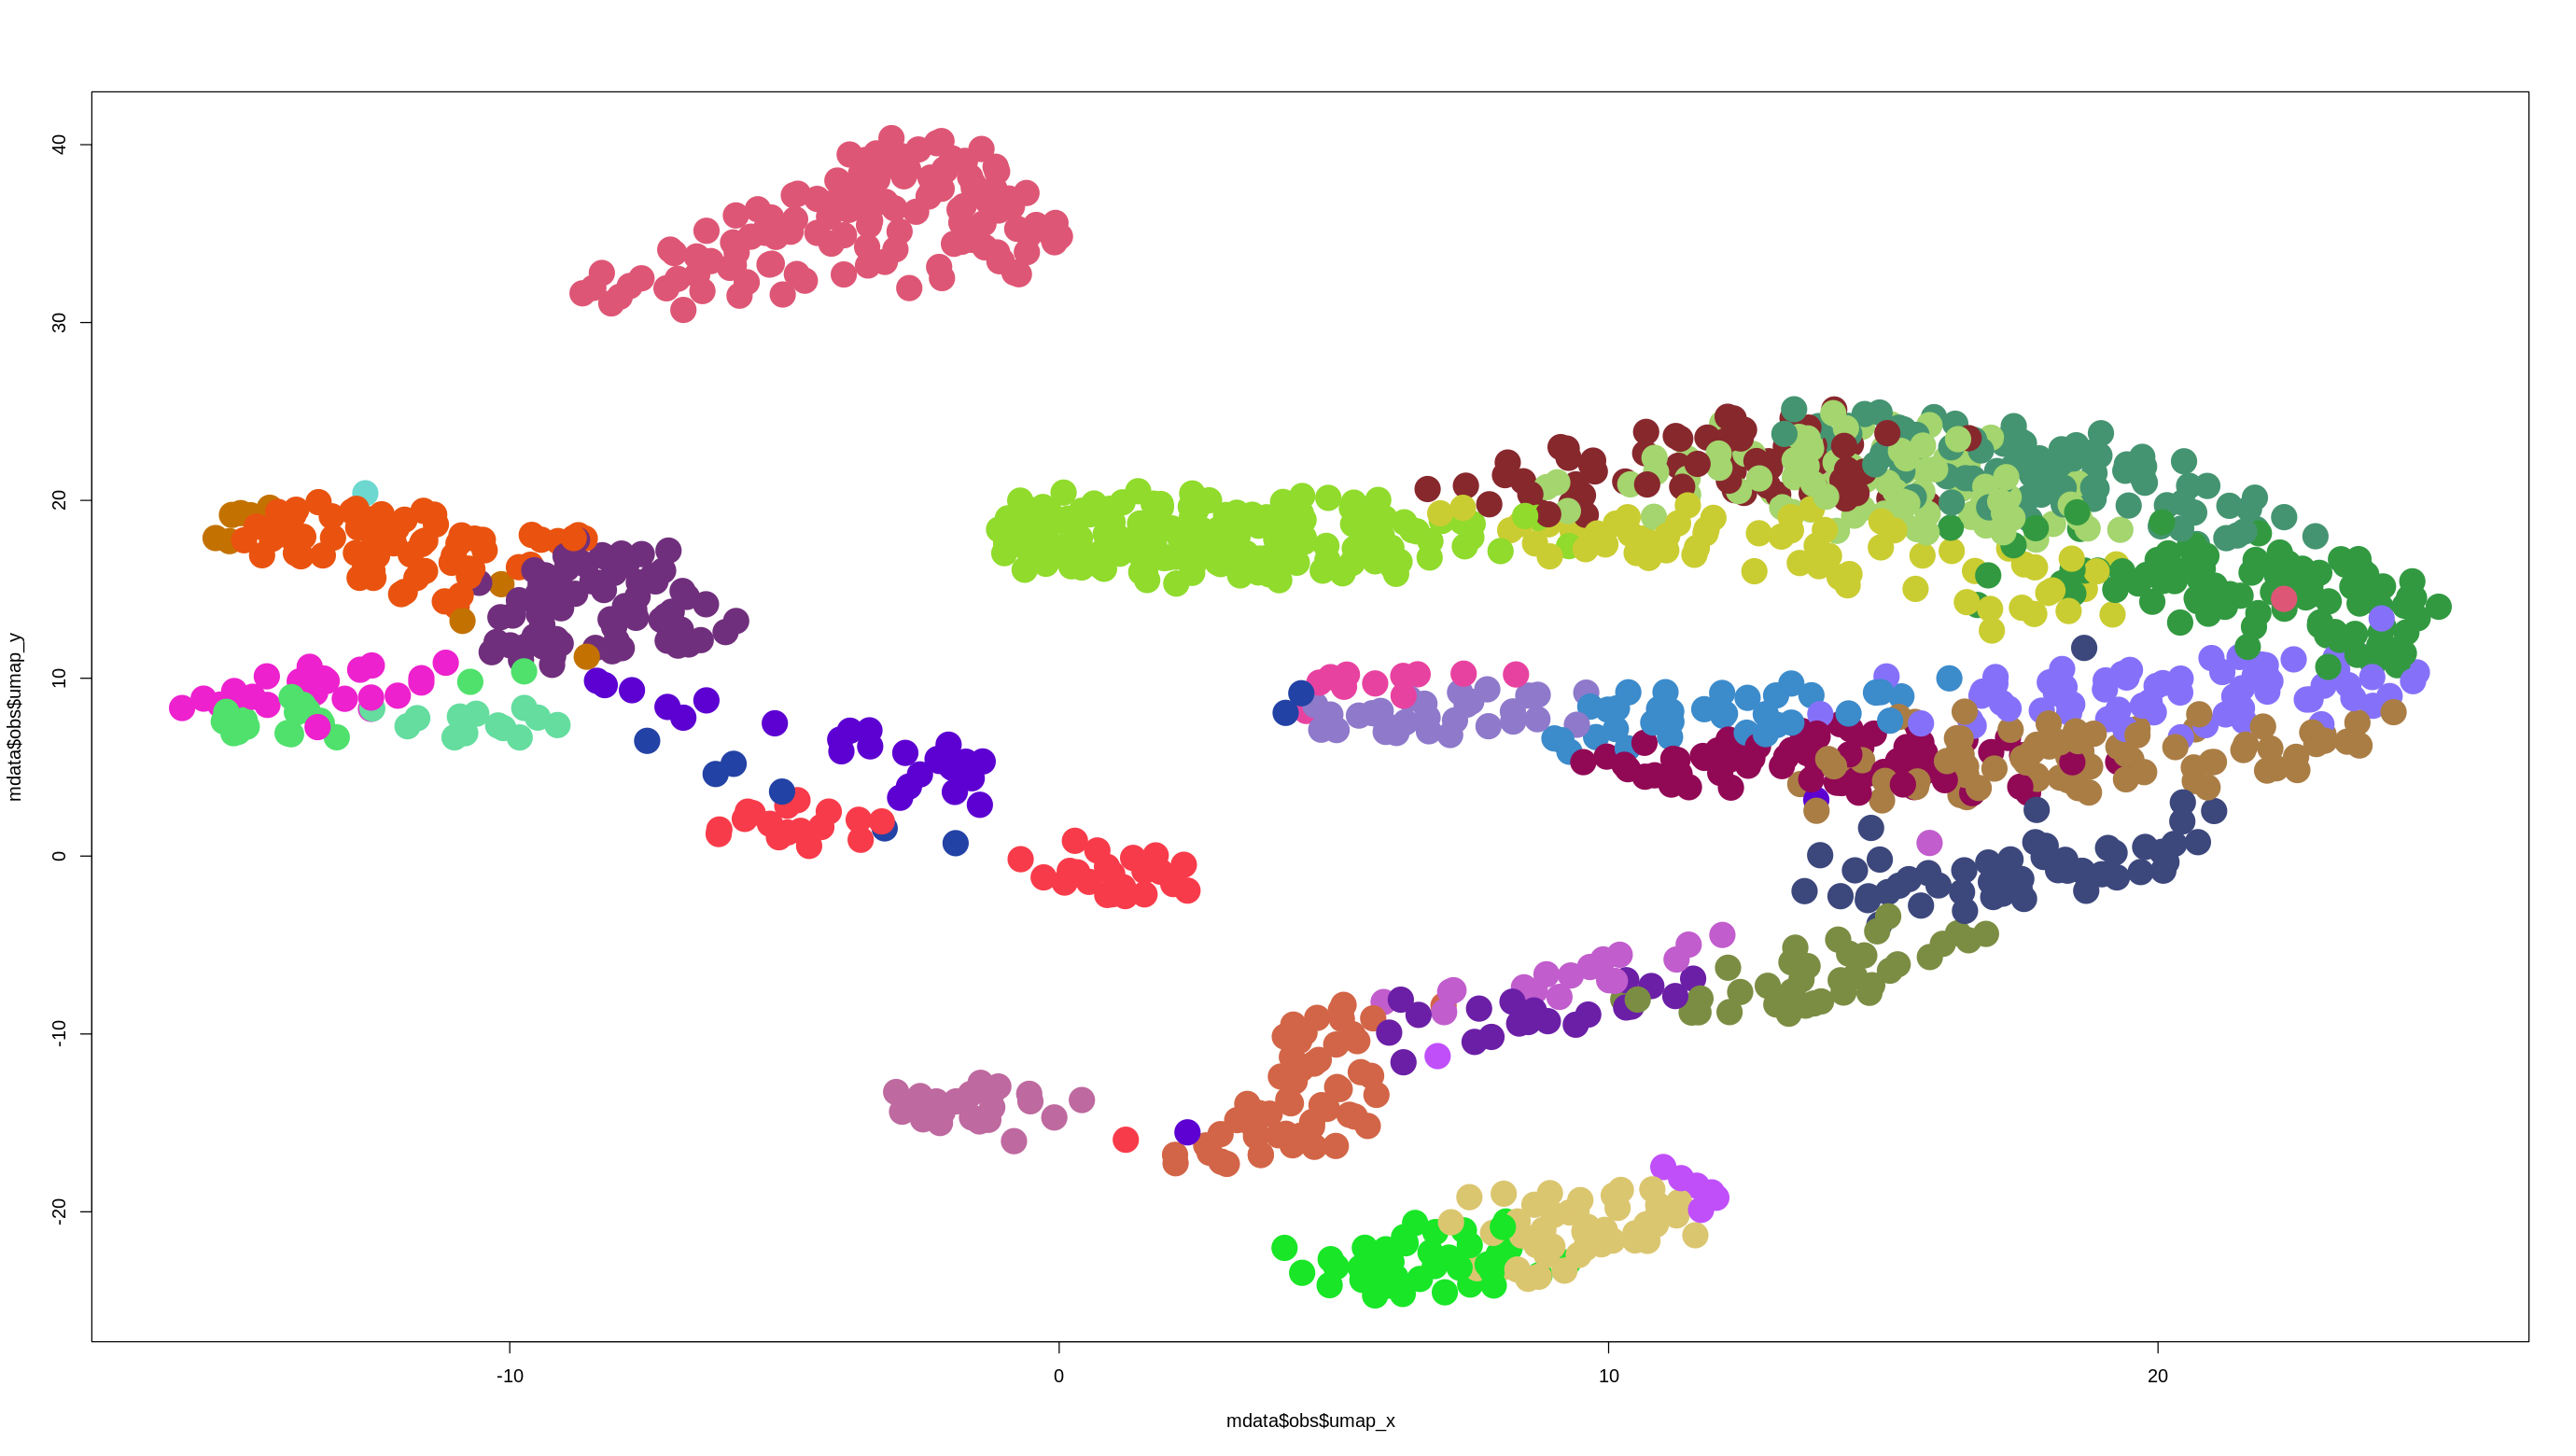

In [9]:
color_of_metacells <- color_of_clusters[cluster_of_metacells]
plot(mdata$obs$umap_x, mdata$obs$umap_y, col=color_of_metacells, pch=19, cex=3)

This shows us a pretty nice locality of the clusters in the 2D UMAP projection, which makes them a good start for the manual analysis. It does not, however, mean that we have exactly 32 distinct behaviors in the data (from actual manual analysis of the data, the number of more like 23). That is, and as is suggested by the projection, in some cases a few clusters cover what we may consider to be a single behavior (possibly artificially quantizing a smooth gradient into distinct steps).

## Gene-Gene Analysis

An effective analysis tool is a gene-gene scatter plot where each point is a metacell, typically colored using some per-metacell annotations (here we'll use the above clusters). These gene-gene scatter plots allow visualizing distinct and gradients of cell behaviors. For example, the following will visualize the gradient of T-cells from naive to effectors, using the GNLY and GZMK gene expression levels:

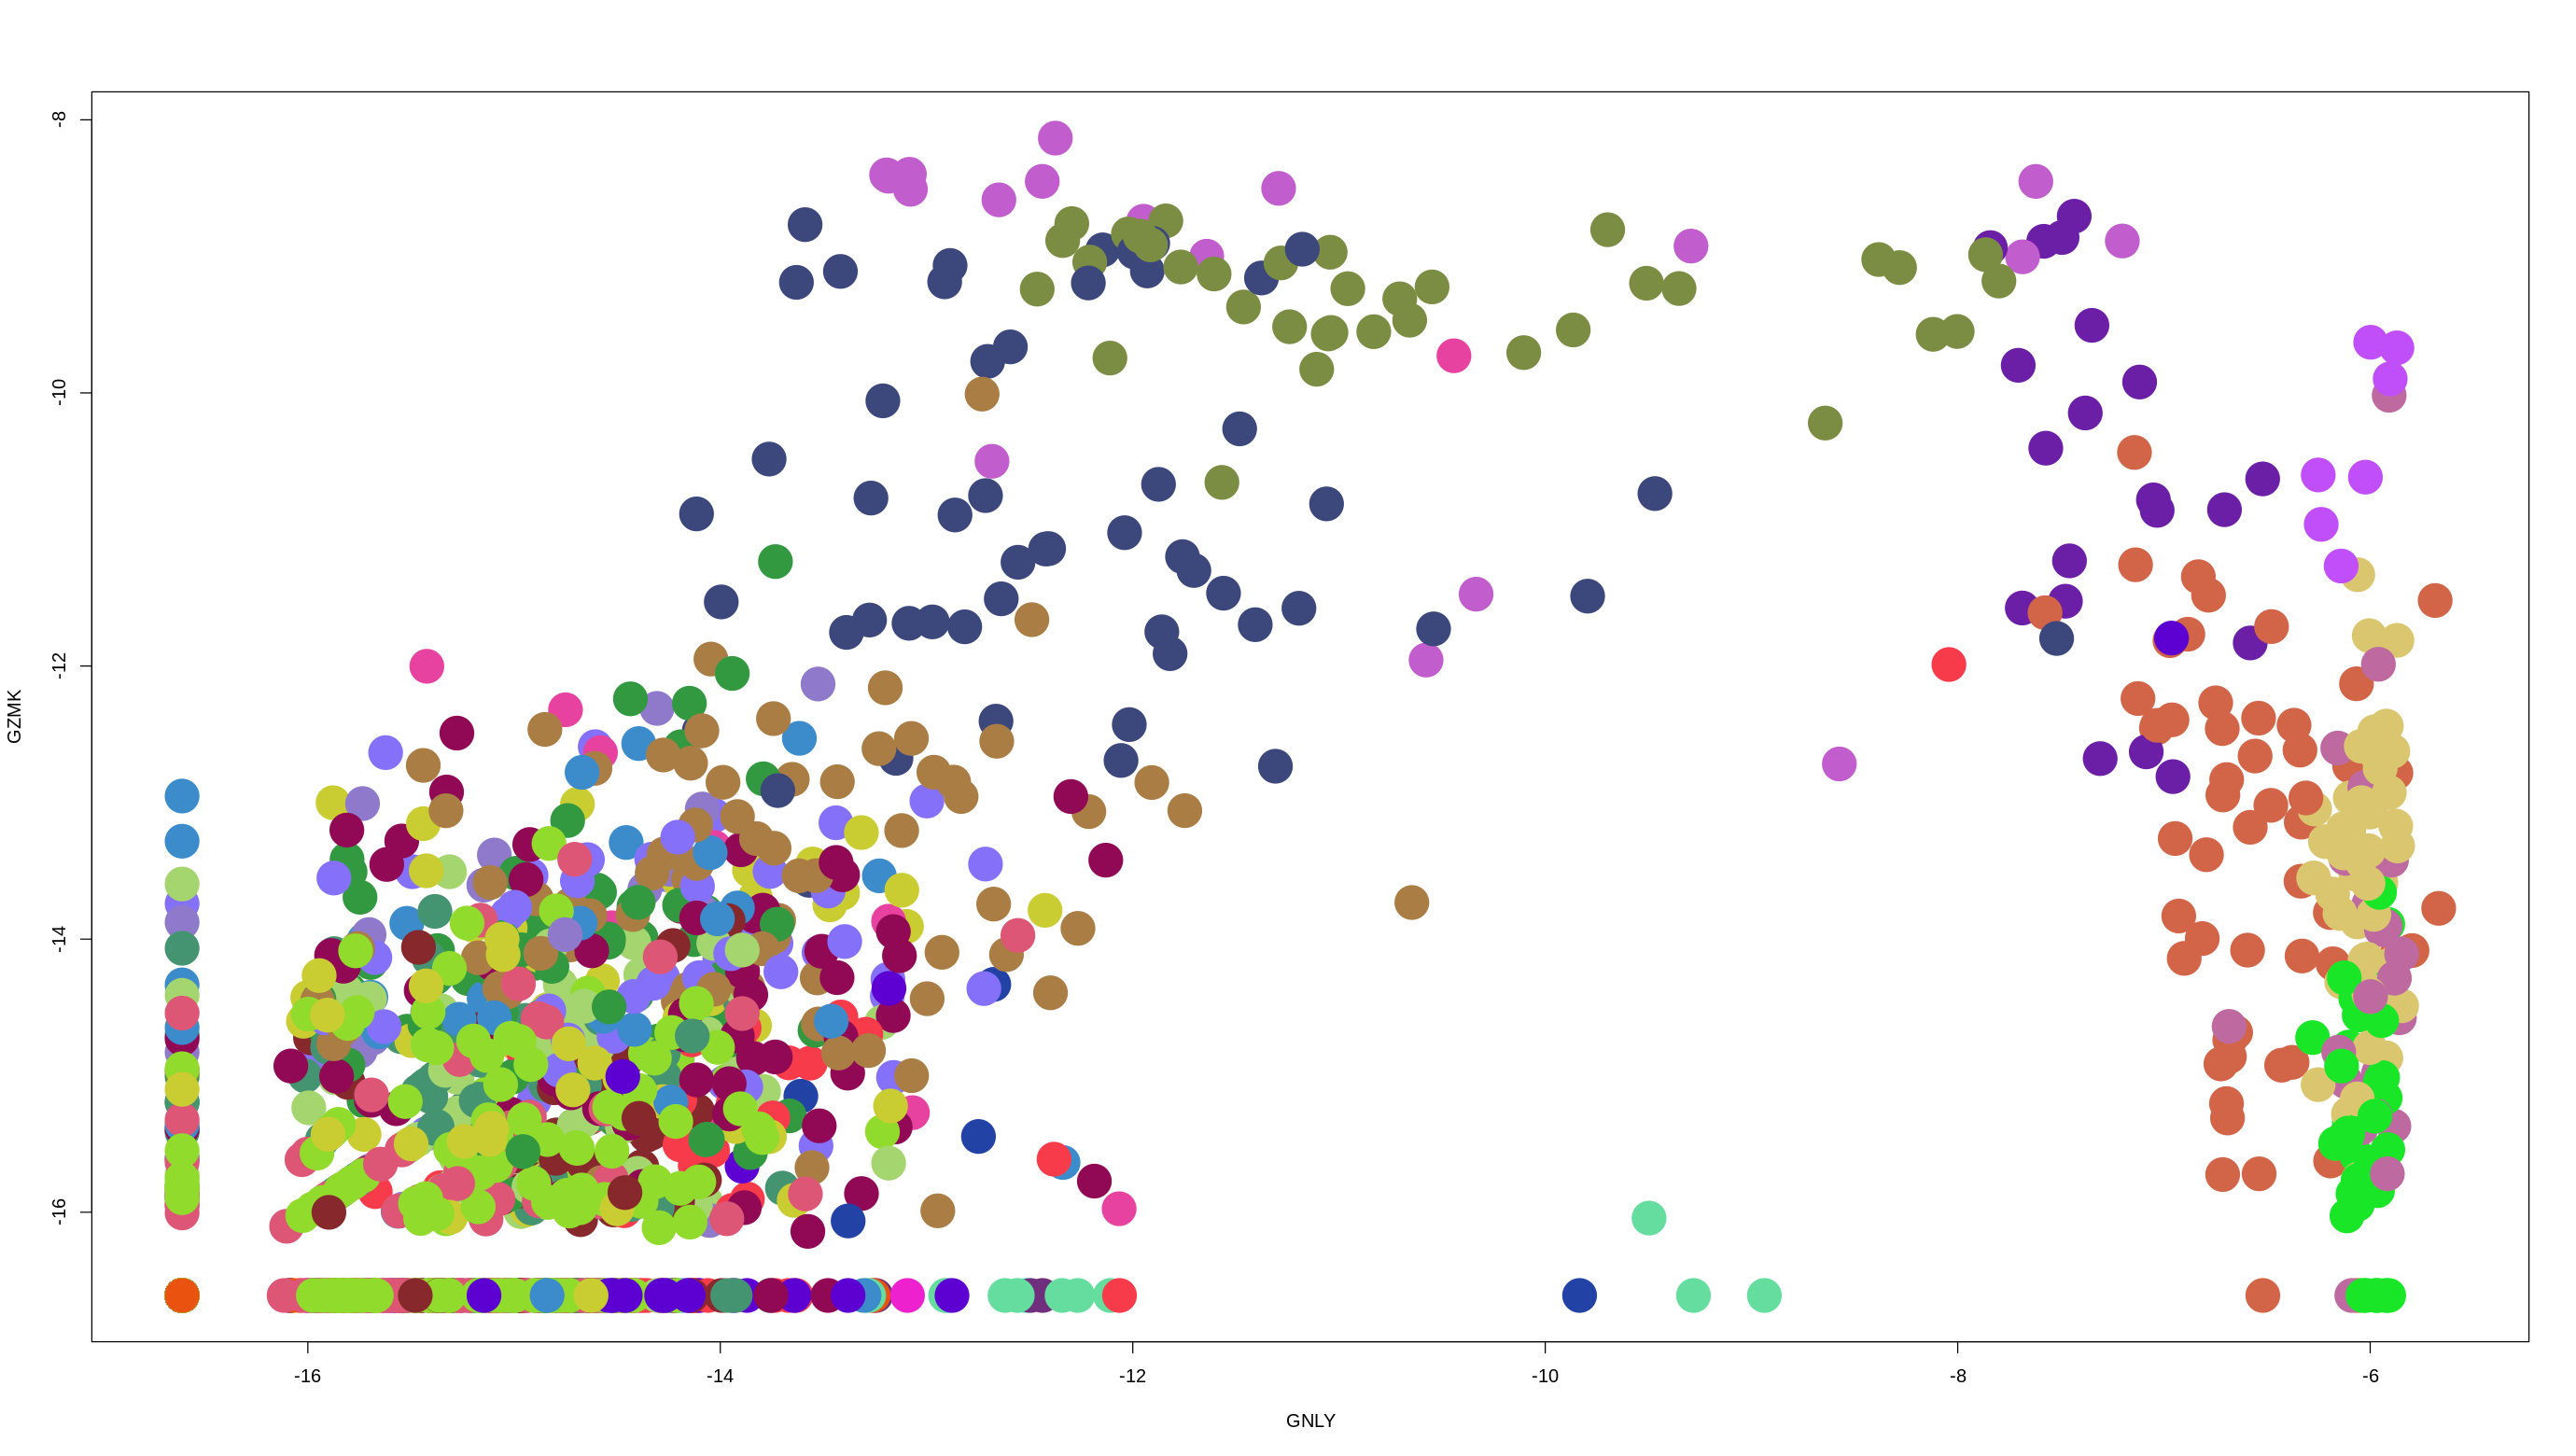

In [10]:
GNLY <- log_fractions[,'GNLY']
GZMK <- log_fractions[,'GZMK']
plot(GNLY, GZMK, col=color_of_metacells, pch=19, cex=4)

## Full Analysis and MCView

A full analysis requires using multiple gene-gene plots to identify marker genes and using them to annotate the metacells with meaningful type labels. Such analysis is labor intensive and is best done using a supporting tool. Sometimes during such analysis one discovers a lateral gene module which threw off the original metacell computation; this requires adding the relevant genes to the forbidden genes list (or in extreme cases, the excluded genes list), and recomputing the metacells, which then requires re-annotating the new metacells. Here again a supporting tool can help in minimizing the effort of annotating the new metacells using the insights gained from analysing the original metacells.

An example of such a manual tool is [MCView](https://tanaylab.github.io/MCView), which provides a convenient GUI for performing such a fuller annalysis. It is convenient to provide this tool with the clusters we computed above to use as a starting point for the analysis. We'll therefore export the clusters data by re-writing the `metacells.h5ad` file to include the per-metacell cluster annotations, and also write a CSV file specifying the cluster colors; these two files can then be imported into MCView for further analysis.

In [11]:
mdata$write_h5ad('metacells.h5ad')
write.csv(list(cluster=1:length(color_of_clusters), color=color_of_clusters),
          row.names=FALSE, file='cluster-colors.csv')

None